In [1]:
import numpy as np
import pandas as pd
import pymc as pm
import arviz as az
import matplotlib.pyplot as plt
import pytensor
import pytensor.tensor as pt

from numba import njit
from pymc.ode import DifferentialEquation
from pytensor.compile.ops import as_op
from scipy.integrate import odeint, solve_ivp
from scipy.optimize import least_squares

In [2]:
print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.27.0


In [3]:
# %load_ext watermark
az.style.use("arviz-darkgrid")
rng = np.random.default_rng(1234)

## Introduction

This notebook investigates how to perform Bayesian inference on a system of ordinary differential equations (ODEs), both with and without gradients.

What we should find: the most simple and efficient method for performing Bayesian inference on the Lotka-Volterra predator-prey model is to specify the ODE system in Scipy, wrap the function as a Pytensor op, and use a Differential Evolution Metropolis (DEMetropolis) sampler in PyMC.

In [4]:
# fmt: off
data = pd.DataFrame(dict(
    year = np.arange(1900., 1921., 1),
    lynx = np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4,
                8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]),
    hare = np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 
                 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])))
data.head()
# fmt: on

,year,lynx,hare
0,1900.0,4.0,30.0
1,1901.0,6.1,47.2
2,1902.0,9.8,70.2
3,1903.0,35.2,77.4
4,1904.0,59.4,36.3


In [5]:
# np.column_stack([
#     np.array([4.0, 6.1, 9.8, 35.2, 59.4, 41.7, 19.0, 13.0, 8.3, 9.1, 7.4, 8.0, 12.3, 19.5, 45.7, 51.1, 29.7, 15.8, 9.7, 10.1, 8.6]), 
#     np.array([30.0, 47.2, 70.2, 77.4, 36.3, 20.6, 18.1, 21.4, 22.0, 25.4, 27.1, 40.3, 57.0, 76.6, 52.3, 19.5, 11.2, 7.6, 14.6, 16.2, 24.7])
# ])

In [6]:
# plot data function for reuse later
def plot_data(ax, lw=2, title="Hudson's Bay Company Data"):
    ax.plot(data.year, data.lynx, color="b", lw=lw, marker="o", markersize=12, label="Lynx (Data)")
    ax.plot(data.year, data.hare, color="g", lw=lw, marker="+", markersize=14, label="Hare (Data)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_xlim([1900, 1920])
    ax.set_ylim(0)
    ax.set_xlabel("Year", fontsize=14)
    ax.set_ylabel("Pelts (Thousands)", fontsize=14)
    ax.set_xticks(data.year.astype(int))
    ax.set_xticklabels(ax.get_xticks(), rotation=45)
    ax.set_title(title, fontsize=16)
    return ax

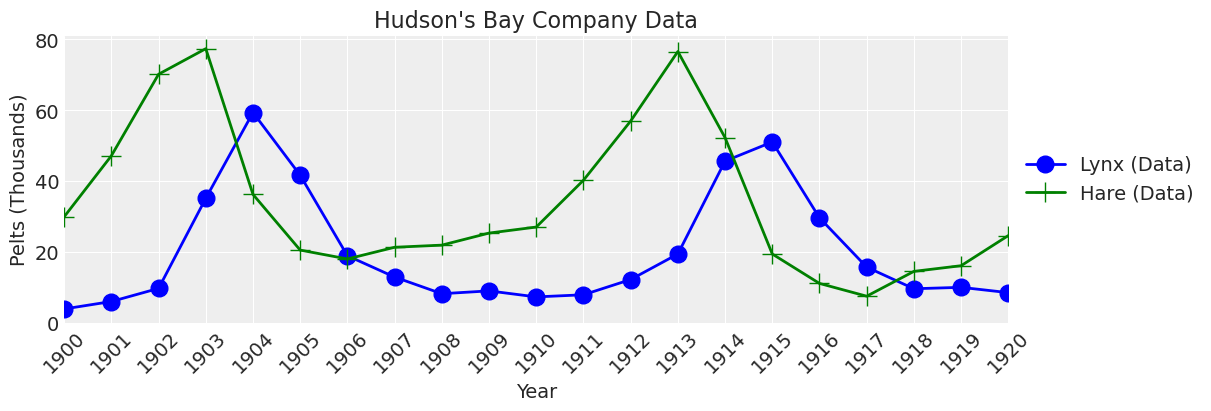

In [7]:
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax);

## Defining the Model

The Lotka–Volterra model is a famous model describing the population dynamics between prey and predators in a population, given by the differential equations:
$$
\frac{dx}{dt} = \alpha x - \beta xy
$$
$$
\frac{dy}{dt} = -\gamma y + \delta xy,
$$
where
- $\alpha$: the prey growth rate when there are no predators
- $\beta$: the death rate of prey in the presence of predation
- $\gamma$: the death rate of predators when there are no prey
- $\delta$: the predator growth rate in the presence of prey

Our goal is to estimate, under uncertainty, the parameters $\theta = (\alpha, \beta, \gamma, \delta)$ for this model.

In [8]:
# Define the right hand side of the Lotka–Volterra equations using call signature required for Scipy's odeint function

@njit
def lotka_volterra(X, t, theta):
    # unpack parameters
    x, y = X
    alpha, beta, gamma, delta, x0, y0 = theta

    # define equations
    dx_dt = alpha * x - beta * (x * y)
    dy_dt = -gamma * y + delta * (x * y)

    return np.array([dx_dt, dy_dt])

In [9]:
# helper function for plotting model
def plot_model(
    ax,
    x_y,
    time=np.arange(1900, 1921, 0.01),
    alpha=1,
    lw=3,
    title="Hudson's Bay Company Data and\nExample Model Run",
):
    ax.plot(time, x_y[:, 1], color="b", alpha=alpha, lw=lw, label="Lynx (Model)")
    ax.plot(time, x_y[:, 0], color="g", alpha=alpha, lw=lw, label="Hare (Model)")
    ax.legend(fontsize=14, loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)
    return ax

In [10]:
# Choose some roughly correct values for theta = (alpha, beta, gamma, delta) and initial states (xt0, yt0)

theta = np.array([0.481, 0.025, 0.926, 0.028, 34.91, 3.86])    # these are actually the least-squares solutions
y0 = np.array([34.91, 3.86])
time = np.arange(1900, 1921, 0.01)

In [11]:
# Call Scipy's odeint function (could alternatively use solve_ivp)
x_y = odeint(func=lotka_volterra, y0=theta[-2:], t=time, args=(theta,))

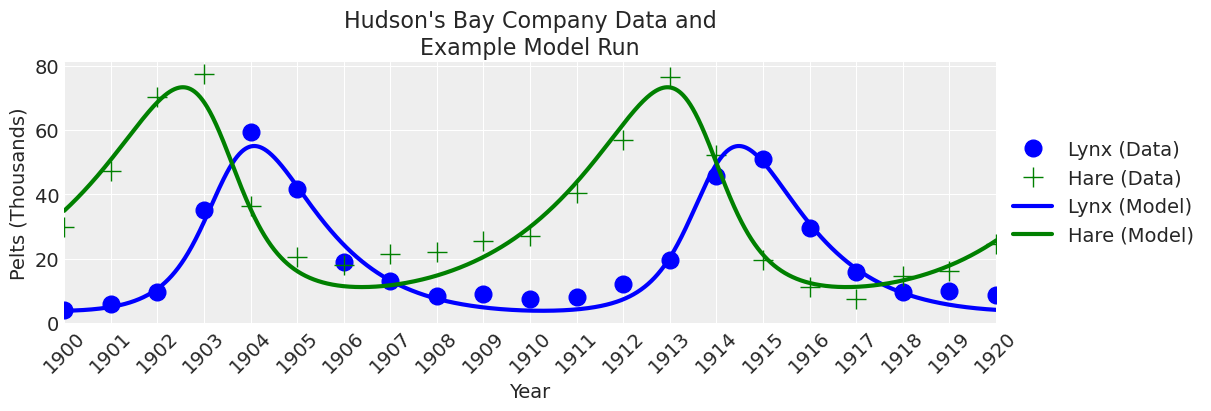

In [12]:
# Test plotting of model and numerical solution obtained using odeint
_, ax = plt.subplots(figsize=(12, 4))
plot_data(ax, lw=0)
plot_model(ax, x_y);

## PyMC Model Specification for (Gradient-Free) Bayesian Inference

In [13]:
# Convert Python Function to a Pytensor Operator using @as_op decorator


In [14]:
def plot_model_trace(ax, trace_df, row_idx, lw=1, alpha=0.2):
    cols = ["alpha", "beta", "gamma", "delta", "xto", "yto"]
    row = trace_df.iloc[row_idx, :][cols].values

    # alpha, beta, gamma, delta, Xt0, Yt0
    time = np.arange(1900, 1921, 0.01)
    theta = row
    x_y = odeint(func=lotka_volterra, y0=theta[-2:], t=time, args=(theta,))
    plot_model(ax, x_y, time=time, lw=lw, alpha=alpha);

In [15]:
def plot_inference(
    ax,
    trace,
    num_samples=25,
    title="Hudson's Bay Company Data and\nInference Model Runs",
    plot_model_kwargs=dict(lw=1, alpha=0.2),
):
    trace_df = az.extract(trace, num_samples=num_samples).to_dataframe()
    plot_data(ax, lw=0)
    for row_idx in range(num_samples):
        plot_model_trace(ax, trace_df, row_idx, **plot_model_kwargs)
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles[:2], labels[:2], loc="center left", bbox_to_anchor=(1, 0.5))
    ax.set_title(title, fontsize=16)

## Inference with Gradient-Based Methods

In [16]:
def lotka_volterra_pymc(y, t, p):
    dX_dt = p[0] * y[0] - p[1] * y[0] * y[1]
    dY_dt = -p[2] * y[1] + p[3] * y[0] * y[1]
    return [dX_dt, dY_dt]

In [17]:
# Specify the ODE
ode_model = DifferentialEquation(
    func=lotka_volterra_pymc, times=data.year.values, n_states=2, n_theta=4, t0=data.year.values[0]
)

In [18]:
theta

array([4.810e-01, 2.500e-02, 9.260e-01, 2.800e-02, 3.491e+01, 3.860e+00])

In [19]:
# Define the PyMC model
with pm.Model() as model:
    # Priors
    alpha = pm.TruncatedNormal("alpha", mu=theta[0], sigma=0.1, lower=0, initval=theta[0])
    beta = pm.TruncatedNormal("beta", mu=theta[1], sigma=0.01, lower=0, initval=theta[1])
    gamma = pm.TruncatedNormal("gamma", mu=theta[2], sigma=0.1, lower=0, initval=theta[2])
    delta = pm.TruncatedNormal("delta", mu=theta[3], sigma=0.01, lower=0, initval=theta[3])
    xt0 = pm.TruncatedNormal("xto", mu=theta[4], sigma=1, lower=0, initval=theta[4])
    yt0 = pm.TruncatedNormal("yto", mu=theta[5], sigma=1, lower=0, initval=theta[5])
    sigma = pm.HalfNormal("sigma", 10)

    # ode_solution
    ode_solution = ode_model(y0=[xt0, yt0], theta=[alpha, beta, gamma, delta])

    # Likelihood
    pm.Normal("Y_obs", mu=ode_solution, sigma=sigma, observed=data[["hare", "lynx"]].values)

In [20]:
# Note: pymc.ode is quite slow!
tune = draws = 15
with model:
    trace_pymc_ode = pm.sample(tune=tune, draws=draws)

Only 15 samples per chain. Reliable r-hat and ESS diagnostics require longer chains for accurate estimate.
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, gamma, delta, xto, yto, sigma]


Output()

 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.5257323572719D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.5257323572719D-13
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.3458406374824D-16
 lsoda--  warning..internal t (=r1) and h (=r2) are  
       such that in the machine, t + h = t on the next step  
       (h = step size). solver will continue anyway  
      in above,  r1 =  0.1900000000000D+04   r2 =  0.3458406374824D-16
 lsoda--  warning..internal t (=r1) 

/usr/local/Caskroom/miniforge/base/envs/pymc_env/lib/python3.11/site-packages/pymc/ode/ode.py:133: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  sol = scipy.integrate.odeint(


Sampling 4 chains for 15 tune and 15 draw iterations (60 + 60 draws total) took 186 seconds.
There were 3 divergences after tuning. Increase `target_accept` or reparameterize.
The number of samples is too small to check convergence reliably.


In [21]:
trace = trace_pymc_ode
az.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.482,0.055,0.417,0.539,0.018,0.018,11.0,16.0,1.69
beta,0.025,0.003,0.020,0.030,0.001,0.000,12.0,20.0,1.42
gamma,0.908,0.074,0.813,1.071,0.024,0.013,11.0,31.0,1.63
delta,0.027,0.003,0.023,0.031,0.001,0.001,10.0,12.0,1.85
xto,35.176,0.783,34.013,36.676,0.146,0.096,25.0,40.0,1.14
yto,4.249,0.378,3.559,4.972,0.078,0.036,25.0,58.0,1.17
sigma,7.078,4.135,3.264,12.658,1.433,1.450,8.0,16.0,2.98


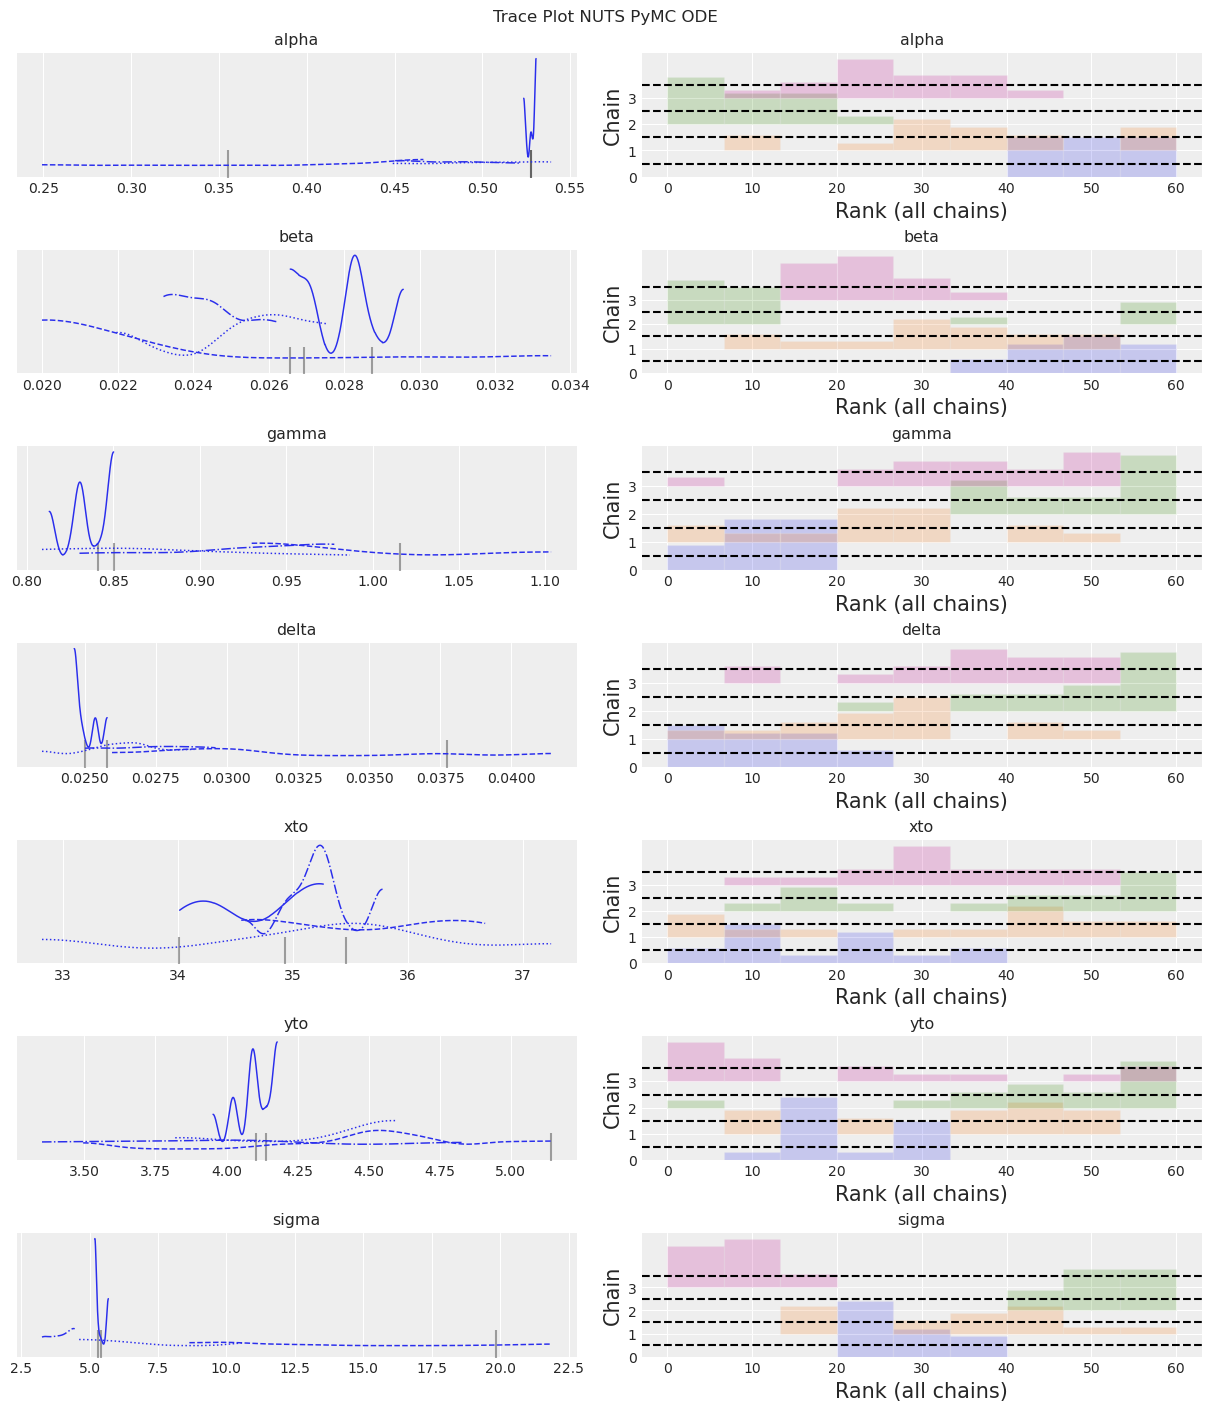

In [22]:
sampler = "NUTS PyMC ODE"
az.plot_trace(trace, kind="rank_bars")
plt.suptitle(f"Trace Plot {sampler}");

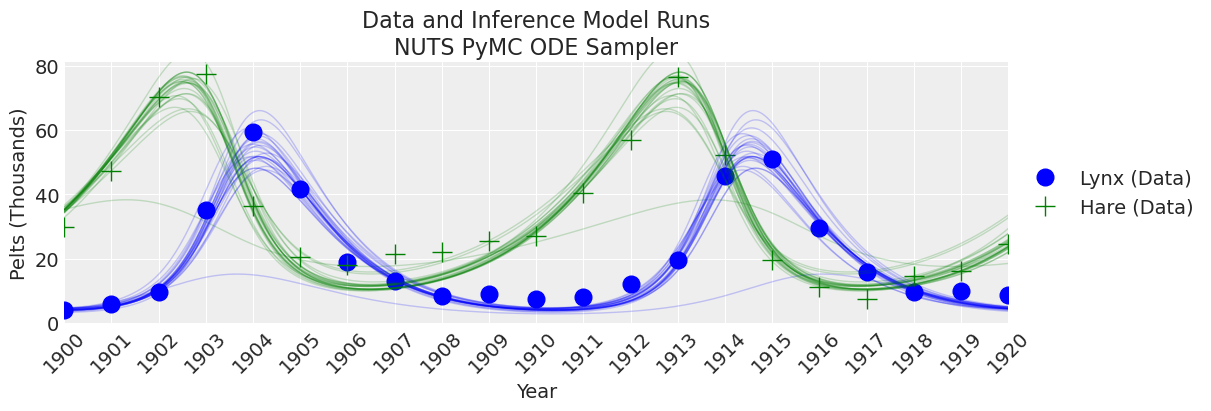

In [23]:
_, ax = plt.subplots(figsize=(12, 4))
plot_inference(ax, trace, title=f"Data and Inference Model Runs\n{sampler} Sampler");